# CIFAR-10 Darknet

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Data Download

CIFAR-10 dataset website: https://www.cs.toronto.edu/~kriz/cifar.html

Direct download link for CIFAR-10 dataset in PNG format (instead of raw Python pickle format): http://files.fast.ai/data/cifar10.tgz

In [37]:
!aria2c --file-allocation=none -c -x 5 -s 5 -d data/ http://files.fast.ai/data/cifar10.tgz

[#380821 144MiB/160MiB(90%) CN:3 DL:22MiB]                        
07/06 16:19:14 [NOTICE] Download complete: data//cifar10.tgz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
380821|OK  |    22MiB/s|data//cifar10.tgz

Status Legend:
(OK):download completed.


In [38]:
!tar -xzf data/cifar10.tgz --directory data/

**Setup directory and file paths**

In [82]:
from fastai.conv_learner import *

PATH = Path('data/cifar10/')
os.makedirs(PATH, exist_ok=True)
torch.cuda.set_device(0)

In [83]:
# My own codes for cutting down the training duration from ~3 hr to ~1hr
torch.backends.cudnn.benchmark = True

Compute CIFAR10 dataset stats

In [43]:
import torchvision.transforms as transforms

# ToTensor() converts image, whose elements ar in the range 0-255 to 0-1
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=train_transform)
# train_set.train_data returns numpy ndarray
# train_set.train_data.shape returns (50000, 32, 32, 3)
print(train_set.train_data.mean(axis=(0, 1, 2)) / 255)
print(train_set.train_data.std(axis=(0, 1, 2)) / 255)

[0.4914  0.48216 0.44653]
[0.24703 0.24349 0.26159]


In [45]:
%rm -rf cifar10/

Build a network from scratch

In [84]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# these numbers are the averages and standard deviations for each channel in CIFAR10
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

num_workers = num_cpus() // 2 # num cpus returns 4
bs = 256
sz = 32

In [85]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz // 8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

Architecture

In [86]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, bias=False, stride=stride, padding=ks // 2),
        nn.BatchNorm2d(num_features=nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)
    )

In [87]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1 = conv_layer(ni, ni // 2, ks=1)
        self.conv2 = conv_layer(ni // 2, ni, ks=3)
        
    def forward(self, x):
        # Received error:
        # "RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation"
        # Others facing this problem: http://forums.fast.ai/t/part-2-lesson-12-wiki/15023/175?u=cedric
        #
        # Jeremy suspect if it only works on Pytorch 0.4:
        # http://forums.fast.ai/t/part-2-lesson-12-wiki/15023/176?u=cedric
        #
        # Disabled for now and replaced with the next line below which does it non in-place.
        # return x.add_(self.conv2(self.conv1(x)))
        return x.add(self.conv2(self.conv1(x)))

In [88]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in * 2, stride=stride)
               ] + [(ResLayer(ch_in * 2)) for i in range(num_blocks)]
    
    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i, nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2 - (i == 1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

**Define `Darknet`**

Create 5 group layers: the first one will contain 1 extra ResLayer, the second will contain 2, then 4, 6, 3 and we want to start with 32 filters. The first one of ResLayers will contain 32 filters, and there’ll just be one extra ResLayer. The second one, it’s going to double the number of filters because that’s what we do each time we have a new group layer. So the second one will have 64, and then 128, 256, 512 and that’ll be it. Nearly all of the network is going to be those bunches of layers and remember, every one of those group layers also has one convolution at the start. So then all we have is before that all happens, we are going to have one convolutional layer at the very start, and at the very end we are going to do our standard adaptive average pooling, flatten, and a linear layer to create the number of classes out at the end.

In [126]:
m = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)
# m = nn.DataParallel(m, [1, 2, 3]) # disabled for single GPU

**Train the model**

In [90]:
lr = 1.3

In [127]:
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd = 1e-4

Fit the model and time it

In [77]:
# before torch.backends.cudnn.benchmark = True
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      2.121895   3.889506   0.2192    
    1      1.833416   2.600925   0.145                      
 99%|█████████▉| 194/196 [06:16<00:03,  1.94s/it, loss=1.67]

KeyboardInterrupt: 

In [92]:
# after torch.backends.cudnn.benchmark = True
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))
# note-to-self:
# a better name for cycle_len -> num_epochs_per_cycle
# The cycle_len parameter governs how long we're going to ride that cosine curve as we decrease the learning rate.
# Cycles are measured in epochs, so cycle_len=1 by itself would mean to continually decrease the learning rate over
# the course of one epoch, and then jump it back up. The cycle_mult parameter says to multiply the length of a cycle
# by something as soon as you finish one.
# So, here we're going to do 1 cycle, of lengths (in epochs): 30. So, 30 epochs in total,
# but our SGDR (not cosine LR because we're using CLR) no restarts.

epoch      trn_loss   val_loss   accuracy                   
    0      2.273209   3.089595   0.1342    
    1      1.943588   2.079482   0.203                      
    2      1.776733   2.449777   0.1387                     
    3      1.633869   1.856296   0.3322                     
    4      1.516814   1.788031   0.3439                     
    5      1.384691   1.658907   0.4009                     
    6      1.215425   1.329689   0.523                      
    7      1.045645   1.808462   0.4049                     
    8      0.944703   1.199622   0.5684                      
    9      0.861089   1.152094   0.5983                      
    10     0.768517   1.26957    0.5655                      
    11     0.715325   1.065744   0.6576                      
    12     0.679374   0.895768   0.6918                      
    13     0.628235   1.363744   0.5982                      
    14     0.611679   1.07958    0.6316                      
    15     0.575896   1.165053   0

[array([0.28104]), 0.911]

### ================================== START DEBUG ==================================

#### Find Learning Rate

In [93]:
learn.lr_find()

 93%|█████████▎| 183/196 [01:31<00:06,  2.01it/s, loss=0.521]

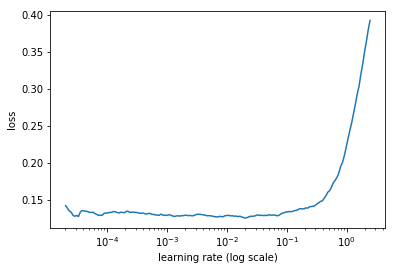

In [95]:
learn.sched.plot()

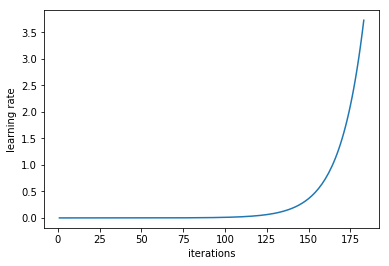

In [96]:
learn.sched.plot_lr()

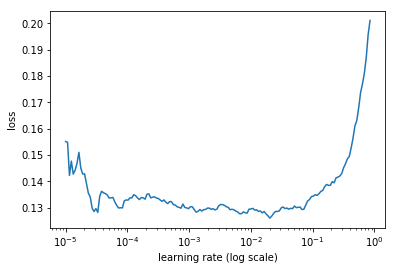

In [100]:
learn.sched.plot(0, 20)

In [101]:
learn.lr_find2()

 48%|████▊     | 95/196 [01:06<01:10,  1.43it/s, loss=0.529]

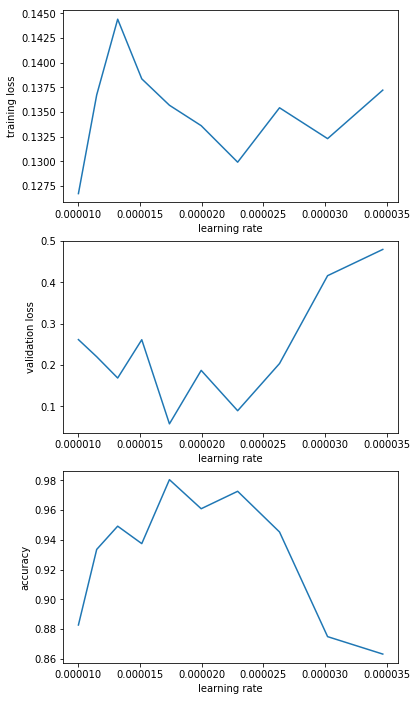

In [120]:
learn.sched.plot(0, 85, smoothed=False)

### ================================== END DEBUG ==================================

#### Experiment with different learning rate

In [125]:
lr = 1.75e-5
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      2.35064    2.318816   0.1       
    1      2.313356   2.311985   0.1072                     
    2      2.277475   2.283653   0.141                      
    3      2.252725   2.246049   0.1651                     
    4      2.228495   2.219853   0.1795                     
 14%|█▍        | 27/196 [00:14<01:30,  1.86it/s, loss=2.22]

KeyboardInterrupt: 

In [128]:
lr = 2e-3
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.885113   2.382229   0.1       
    1      1.563582   2.904207   0.1165                     
    2      1.370303   1.344049   0.5285                     
    3      1.202677   1.370056   0.5243                     
    4      1.106625   1.159941   0.5755                     
    5      1.0138     1.018526   0.6401                     
    6      0.944485   1.073753   0.6367                      
    7      0.871943   1.083816   0.6317                      
    8      0.827627   1.069024   0.6304                      
    9      0.79562    0.862613   0.6942                      
    10     0.747476   0.837587   0.7117                      
    11     0.703309   0.772034   0.7273                      
    12     0.672228   0.822387   0.7172                      
    13     0.631399   0.746245   0.7452                      
    14     0.595418   0.722072   0.7518                      
    15     0.562507   0.7937    

[array([0.48352]), 0.8374]

In [129]:
# My own code for testing

def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

In [130]:
get_TTA_accuracy(learn)

0.8516

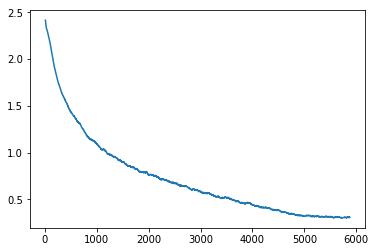

In [131]:
# My own code for testing

learn.sched.plot_loss()

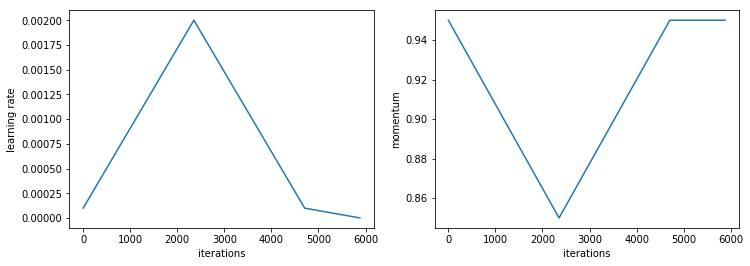

In [132]:
# My own code for testing

learn.sched.plot_lr()

In [133]:
learn.save('darknet_lr_3e-2')

**_Note: I didn't try the other experiments in the original notebook._**